In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import seaborn as sns

### UNET STRUCTURE

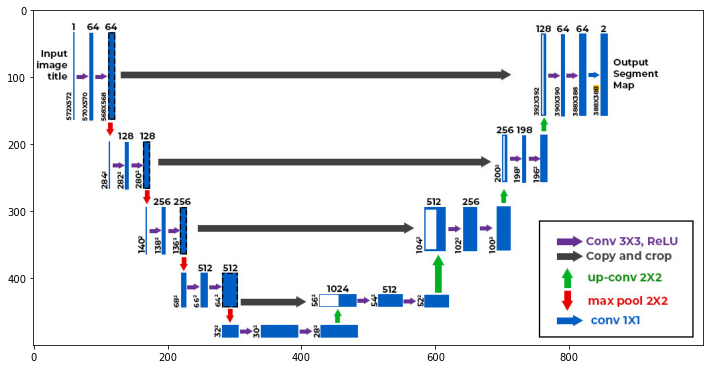

In [2]:
image = plt.imread("unet.png")
plt.figure(figsize=(12,12))
plt.imshow(image)

### Creating U-Net from scratch

In [3]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [4]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [5]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [6]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [7]:
#### Trying to see if it works
example_input = torch.rand((1,3,224,224)) ## Batch,channel,H,W

In [8]:
model = build_unet()
model(example_input).shape

torch.Size([1, 1, 224, 224])

### Dataset dataloader

In [9]:
class MoldDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.root_path = "C:\\Users\\user\\Desktop\\smart-fridge"
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.root_path+"\\peach\\"+self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        mask_path = os.path.join(self.root_path, "masks", self.image_paths[idx].replace(".jpg", ".png").replace(".JPG", ".png"))
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

### Splitting data into train,val and test(80%,10%,10%)

In [10]:
image_paths = os.listdir("C:\\Users\\user\\Desktop\\smart-fridge\\peach")
mask_paths = os.listdir("C:\\Users\\user\\Desktop\\smart-fridge\\masks")

(
    train_image_paths,
    tval_image_paths,
    train_mask_paths,
    tval_mask_paths,
) = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)

val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    tval_image_paths, tval_mask_paths, test_size=0.5, random_state=42
)

train_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)

In [11]:
len(train_image_paths),len(test_image_paths), len(val_image_paths)

(176, 38, 38)

In [12]:
# Create the train and test datasets
train_dataset = MoldDataset(train_image_paths, train_mask_paths, train_transform)
test_dataset = MoldDataset(test_image_paths, test_mask_paths, test_transform)
val_dataset = MoldDataset(val_image_paths, val_mask_paths, test_transform)

# Create train and test data loaders
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [13]:
i, (image, mask) = next(enumerate(train_dataset))

In [14]:
image.shape, mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

### Example image and it's mask higlihted over image

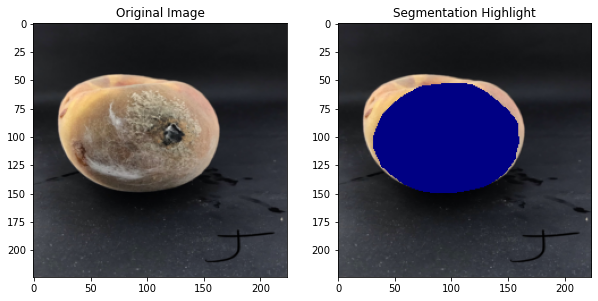

In [25]:
image, mask = val_dataset[25]

image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
mask = mask.squeeze().numpy()  # Remove the channel dimension and convert from (1, H, W) to (H, W)
mask = np.where(mask!=0,1,0)
# Create a color mask by applying a colormap to the segmentation mask
cmap = plt.get_cmap('jet') 
masked_image = image.copy()
mask_indices = np.where(mask!=0) # Find the indices where mask is non-zero
masked_image[mask_indices] = cmap(mask[mask_indices])[:, :3]  


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(masked_image)
axes[1].set_title('Segmentation Highlight')
plt.show()

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Combining dice loss and binary cross entropy loss

In [27]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-7):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth

    def dice_loss(self, inputs, targets):
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        dice_loss_val = self.dice_loss(torch.sigmoid(inputs), targets)
        combined_loss = self.alpha * bce_loss + (1 - self.alpha) * dice_loss_val
        return combined_loss

### BCE loss model

In [28]:
model_1 = build_unet()
model_1 = model_1.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.4, verbose=True
)

# Training loop
num_epochs = 40

# Initialize the counter for consecutive non-decreasing epochs
non_decreasing_epochs = 0
best_val_loss = np.inf

for epoch in range(num_epochs):
    model_1.train()  # Set model in training mode
    for images, masks in tqdm(train_data_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model_1(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Evaluate on val set
    model_1.eval()  # Set model in evaluation model
    with torch.no_grad():
        total_loss = 0
        for images, masks in val_data_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_1(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

        val_loss = total_loss / len(val_data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], val loss: {val_loss:.4f}")

        # Check if the validation loss has decreased
        if val_loss < best_val_loss:
            non_decreasing_epochs = 0
            best_val_loss = val_loss

        else:
            non_decreasing_epochs += 1

        scheduler.step()

        # Check if training should be stopped
        if non_decreasing_epochs >= 3:
            print("Validation loss has not decreased for 3 epochs. Stopping training.")
            break

# Save the trained model
torch.save(model_1.state_dict(), "C:\\Users\\user\\Desktop\\smart-fridge\\model.pth")

Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


Epoch [1/40], val loss: 0.6175
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


Epoch [2/40], val loss: 0.4899
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [3/40], val loss: 0.4040
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [4/40], val loss: 0.3511
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [5/40], val loss: 0.3121
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [6/40], val loss: 0.2886
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [7/40], val loss: 0.2779
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [8/40], val loss: 0.2687
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [9/40], val loss: 0.2764
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [10/40], val loss: 0.2622
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [11/40], val loss: 0.2571
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [12/40], val loss: 0.2530
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [13/40], val loss: 0.2519
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [14/40], val loss: 0.2460
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Epoch [15/40], val loss: 0.2467
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [16/40], val loss: 0.2462
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [17/40], val loss: 0.2466
Adjusting learning rate of group 0 to 1.9200e-05.
Validation loss has not decreased for 3 epochs. Stopping training.


### Combined loss model

In [29]:
model_2 = build_unet()
model_2 = model_2.to(device)

# Define the loss function and optimizer
criterion = CombinedLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.4, verbose=True
)

# Training loop
num_epochs = 40

# Initialize the counter for consecutive non-decreasing epochs
non_decreasing_epochs = 0
best_val_loss = np.inf
for epoch in range(num_epochs):
    model_2.train()  # Set model in training mode
    for images, masks in tqdm(train_data_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model_2(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Evaluate on val set
    model_2.eval()  # Set model in evaluation model
    with torch.no_grad():
        total_loss = 0
        for images, masks in val_data_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_2(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

        val_loss = total_loss / len(val_data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], val loss: {val_loss:.4f}")

        # Check if the validation loss has decreased
        if val_loss < best_val_loss:
            non_decreasing_epochs = 0
            best_val_loss = val_loss

        else:
            non_decreasing_epochs += 1

        scheduler.step()

        # Check if training should be stopped
        if non_decreasing_epochs >= 3:
            print("Validation loss has not decreased for 3 epochs. Stopping training.")
            break

# Save the trained model
torch.save(
    model_2.state_dict(), "C:\\Users\\user\\Desktop\\smart-fridge\\model_comb.pth"
)

Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [1/40], val loss: 0.7030
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [2/40], val loss: 0.6225
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Epoch [3/40], val loss: 0.5676
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [4/40], val loss: 0.5137
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [5/40], val loss: 0.5763
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch [6/40], val loss: 0.4278
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [7/40], val loss: 0.4079
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


Epoch [8/40], val loss: 0.4028
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Epoch [9/40], val loss: 0.3922
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Epoch [10/40], val loss: 0.4054
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [11/40], val loss: 0.3863
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [12/40], val loss: 0.3846
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [13/40], val loss: 0.4002
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [14/40], val loss: 0.3780
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Epoch [15/40], val loss: 0.3779
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch [16/40], val loss: 0.3792
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch [17/40], val loss: 0.3748
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch [18/40], val loss: 0.3776
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


Epoch [19/40], val loss: 0.3796
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Epoch [20/40], val loss: 0.3744
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Epoch [21/40], val loss: 0.3684
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 11/11 [00:12<00:00,  1.16s/it]


Epoch [22/40], val loss: 0.3726
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Epoch [23/40], val loss: 0.3689
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Epoch [24/40], val loss: 0.3687
Adjusting learning rate of group 0 to 7.6800e-06.
Validation loss has not decreased for 3 epochs. Stopping training.


### Results and Evaluation

In [30]:
model_1.to("cpu")
model_2.to("cpu")

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [50]:
idx = np.random.randint(0, len(test_image_paths), 4).astype(int)

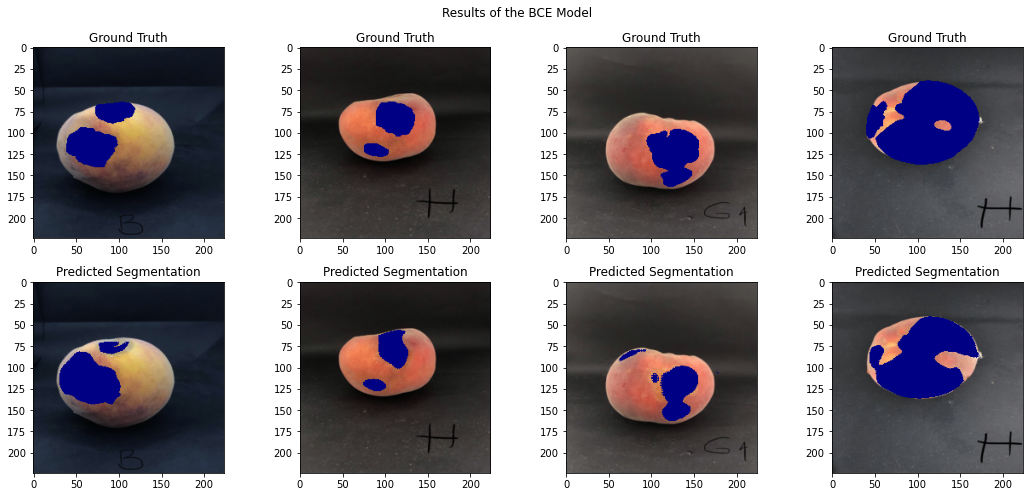

In [51]:
fig, ax = plt.subplots(2, 4,figsize=(15, 7))
fig.suptitle("Results of the BCE Model")
for i, elm in enumerate(idx):
    image, mask = test_dataset[elm]
    preds = torch.sigmoid(model_1(image.unsqueeze(0)))
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    mask = mask.squeeze().numpy()  # Remove the channel dimension and convert from (1, H, W) to (H, W)
    mask = np.where(mask !=0,1,0)
    preds = preds.detach().squeeze().numpy()
    preds = np.where(preds>=0.5,1,0)
    masked_image = image.copy()
    output = image.copy()
    mask_indices = np.where(mask ==1)  # Find the indices where mask is non-zero
    pred_indices = np.where(preds ==1)
    masked_image[mask_indices] = cmap(mask[mask_indices])[:, :3]
    output[pred_indices] = cmap(preds[pred_indices])[:, :3]
    ax[0, i].set_title('Ground Truth')
    ax[0, i].imshow(masked_image)
    ax[1, i].set_title('Predicted Segmentation')
    ax[1, i].imshow(output)

plt.tight_layout()
plt.show()

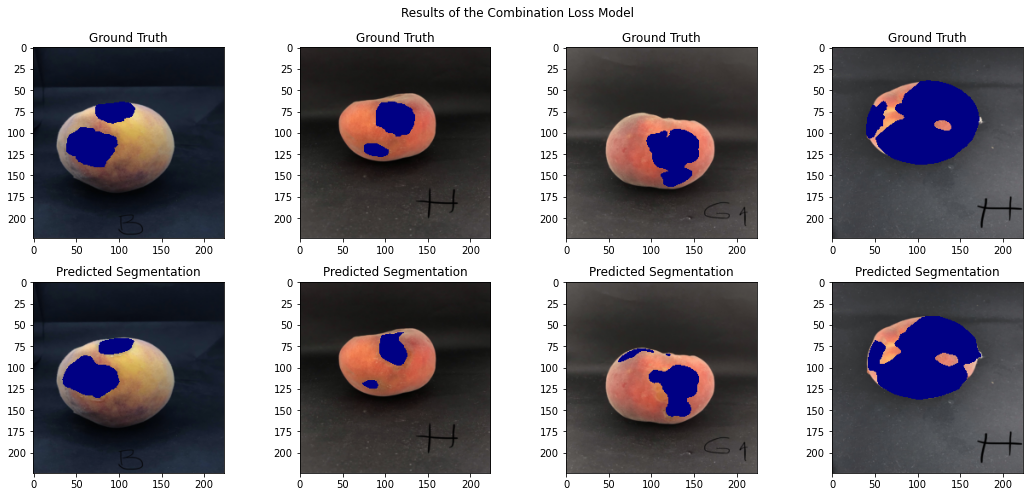

In [52]:
fig, ax = plt.subplots(2, 4,figsize=(15, 7))
fig.suptitle("Results of the Combination Loss Model")
for i, elm in enumerate(idx):
    image, mask = test_dataset[elm]
    preds = torch.sigmoid(model_2(image.unsqueeze(0)))
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    mask = mask.squeeze().numpy()  # Remove the channel dimension and convert from (1, H, W) to (H, W)
    mask = np.where(mask !=0,1,0)
    preds = preds.detach().squeeze().numpy()
    preds = np.where(preds>=0.5,1,0)
    masked_image = image.copy()
    output = image.copy()
    mask_indices = np.where(mask ==1)  # Find the indices where mask is non-zero
    pred_indices = np.where(preds ==1)
    masked_image[mask_indices] = cmap(mask[mask_indices])[:, :3]
    output[pred_indices] = cmap(preds[pred_indices])[:, :3]
    ax[0, i].set_title('Ground Truth')
    ax[0, i].imshow(masked_image)
    ax[1, i].set_title('Predicted Segmentation')
    ax[1, i].imshow(output)

plt.tight_layout()
plt.show()

In [34]:
def eval_metrics(preds,mask):
    intersection = torch.sum(preds * mask)
    union = torch.logical_or(preds, mask).sum().item()
    iou_score = intersection / union
    dice_coefficient = (2 * intersection) / (union + intersection + 1e-9)
    false_p = torch.sum(preds)-intersection
    false_n = torch.sum(mask)-intersection
    precision = intersection/(intersection + false_p +  1e-9)
    recall = intersection/(intersection + false_n +  1e-9)
    
    return iou_score,dice_coefficient,precision,recall


def evaluate(model):
    ious = []
    dice_coefs = []
    precisions = [] 
    recalls = []
    with torch.no_grad():
        for batch in tqdm(test_data_loader):
            for i in range(batch[0].shape[0]):
                image = batch[0][i]
                image = image.unsqueeze(0)
                mask = batch[1][i]
                mask = mask.unsqueeze(0)
                out = torch.sigmoid(model(image))

                out = torch.where(out>=0.5,1,0)
                mask = torch.where(mask!=0,1,0)

                iou,dice_coef,precision,recall = eval_metrics(out,mask)
                ious.append(iou.item())
                dice_coefs.append(dice_coef.item())
                precisions.append(precision.item())
                recalls.append(recall.item())
                
    return ious,dice_coefs,precisions,recalls

In [35]:
ious_1,dice_coefs_1,precisions_1,recalls_1 = evaluate(model_1)
ious_2,dice_coefs_2,precisions_2,recalls_2 = evaluate(model_2)

100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


In [36]:
accuracy_1 = len(np.where(np.array(ious_1)>0.5)[0])/len(ious_1)
accuracy_2 = len(np.where(np.array(ious_2)>0.5)[0])/len(ious_2)
accuracy_1,accuracy_2

(0.8157894736842105, 0.7894736842105263)

In [37]:
np.mean(dice_coefs_1),np.mean(dice_coefs_2)

(0.7596127606536213, 0.7616920504522952)

In [38]:
np.mean(precisions_1),np.mean(precisions_2)

(0.798448740651733, 0.8184267043283111)

In [39]:
np.mean(recalls_1),np.mean(recalls_2)

(0.7445214704463357, 0.7604515724080173)

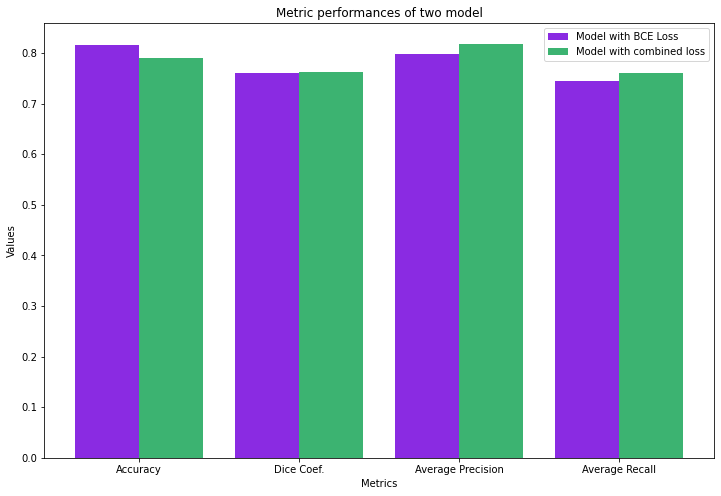

In [40]:
metrics = ["Accuracy", "Dice Coef.", "Average Precision", "Average Recall"]

bce_metrics = [accuracy_1, np.mean(dice_coefs_1), np.mean(precisions_1), np.mean(recalls_1)]
combined_metrics = [accuracy_2, np.mean(dice_coefs_2), np.mean(precisions_2), np.mean(recalls_2)]

X_axis = np.arange(len(metrics))

plt.figure(figsize=(12, 8))
plt.bar(X_axis - 0.2, bce_metrics, 0.4, label="Model with BCE Loss", color="blueviolet")
plt.bar(
    X_axis + 0.2,
    combined_metrics,
    0.4,
    label="Model with Combined Loss",
    color="mediumseagreen",
)

plt.xticks(X_axis, metrics)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Metric performances of two model")

plt.legend()
plt.show()